<a href="https://colab.research.google.com/github/benisalla/BIA-Bilingual-Net/blob/main/BE2_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install + import of all packages

### Some Pre-Configurations For Java:

> 1) sys.path.append: Adds the path to the Java binary (java) to Python's sys.path, ensuring that the Python interpreter can find the Java runtime when needed.


> 2) os.environ["JAVA_HOME"]: Sets the JAVA_HOME environment variable to the Java installation directory. This is critical for any Java-based application, including WEKA, as it uses this variable to locate the Java runtime.

> 3) build-essential: Installs essential compilation tools (like gcc, make) required for building Python-Java bridges.

### Installing python-java related liberaries:

> 1) python3-dev: Provides the header files needed for building Python modules that interface with Java.


> 2) python3-pil: A Python library for image processing, which might be required by WEKA's visualization tools.

> 3) python3-pygraphviz: Supports graph visualizations, sometimes used in decision trees or other WEKA models.

> 4) openjdk-11-jdk: Installs the OpenJDK 11 Java Development Kit, which provides the Java runtime required to run WEKA.

> 5) javabridge: A Python library that creates a bridge between Python and Java, enabling Python code to interact with Java applications like WEKA.
It ensures seamless communication between Python scripts and the underlying WEKA Java codebase.

> 6) python-weka-wrapper3: A wrapper that makes WEKA's Java functionality accessible in Python.

> 7) This is specifically for WEKA 3.x versions, which are compatible with Java 11 and Python 3.


> 8) The wrapper leverages javabridge to execute WEKA methods directly from Python, allowing for scripting, data loading, and model training within Python.

In [ ]:
%%capture
import os
import sys
sys.path
sys.path.append("/usr/lib/jvm/java-11-openjdk-amd64/bin/")
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64/"
!apt-get install build-essential python3-dev
!apt-get install python3-pil python3-pygraphviz
!apt install openjdk-11-jdk
!pip3 install javabridge --no-cache-dir
!pip3 install python-weka-wrapper3 --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np
import pydot                                # extremly important for visualization !!!!
from IPython.display import Image, display  # these Objects too !!!!
import matplotlib.pyplot as plt
import seaborn as sns
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random

In [ ]:
# Before Running Python commands to intract with weka(java)
# we have to start jvm (Java Virtual Machine = to run java programs)
if not jvm.started:
    jvm.start()
else:
    print("JVM is already running!")

JVM is already running!


# My Helpers

Before we begin our tasks, it is better to write down all the helpers and classes that will make training, validation, and testing easier later.

I will work in this exercise with Weka functions and models since RepTree is already developed in Weka.


In [ ]:
def dataframe_to_arff(df: pd.DataFrame, relation_name: str = "relation"):
    """
    Converts a pandas DataFrame to an ARFF (Attribute-Relation File Format) file for use with WEKA.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to be converted.
    - relation_name (str): Name of the relation/dataset. This will appear at the top of the ARFF file.

    Example ARFF file format:
    -------------------------
    @relation cars

    @attribute Pachat {thaut,haut,moyen,bas}
    @attribute Pmaint {thaut,haut,moyen,bas}
    @attribute Nportes {2,3,4,5plus}
    @attribute Npers {2,4,plus}
    @attribute Tcoffre {petit,moyen,grand}
    @attribute Surete {bas,moyen,haut}
    @attribute Verdict {nacc,acc,tbon,bon}

    @data
    thaut,thaut,2,2,petit,bas,nacc
    thaut,thaut,2,2,petit,moyen,nacc
    thaut,thaut,2,2,petit,haut,nacc
    thaut,thaut,2,2,moyen,bas,nacc
    ...

    The resulting ARFF file is saved as '<relation_name>.arff'.
    """

    # Open the file for writing. Overwrites the file if it already exists.
    with open(f"{relation_name}.arff", "w") as f:
        # Write the relation section
        f.write(f"@relation {relation_name}\n\n")

        # Write the attribute section
        for col in df.columns:
            # Determine the attribute type based on the column's dtype
            if df[col].dtype == 'object' or df[col].dtype.name == 'category':  # Categorical attributes
                unique_vals = df[col].dropna().unique()  # Exclude NaN values
                unique_vals_str = ",".join(map(str, unique_vals))  # Format values as a comma-separated string
                f.write(f"@attribute {col} {{{unique_vals_str}}}\n")
            elif df[col].dtype in ('int64', 'float64'):  # Numeric attributes
                f.write(f"@attribute {col} numeric\n")
            else:
                raise ValueError(f"Unsupported data type for column '{col}': {df[col].dtype}")

        # Write the data section
        f.write("\n@data\n")
        for _, row in df.iterrows():
            f.write(",".join(map(str, row.values)) + "\n")

class WekaModel:
    def __init__(self, model_type, model_params=None):
        """
        I have tried to make this model generic: it can run any Weka model.
        I just have to specify the model type and model parameters.

        Like:
        model_params = {"M": 2}
        model_type = "weka.classifiers.trees.REPTree"

        In simple words, we are just consuming Weka APIs in a Colab notebook :)
        """
        self.model_type = model_type
        self.model_params = model_params or {}
        self.tree_img_name = f"{model_type}_tree.png"
        self.model = Classifier(classname=model_type, options=self._dict_to_options(model_params))
        self.data = None
        self.evaluation = None
        self.run_info = {}

    def load_data(self, csv_path, target_class):
        """
        Load data from an ARFF file and set the target class by name.
        """
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"File not found: {csv_path}")

        # let's first create arff file from csv file
        dataframe_to_arff(pd.read_csv(csv_path), relation_name="cars")

        # now we can load arff file :)
        arff_path = csv_path.replace(".csv", ".arff")
        loader = Loader(classname="weka.core.converters.ArffLoader")
        self.data = loader.load_file(arff_path)

        # let's make sure our target exists in columns of our dataset
        if target_class not in self.data.attribute_names():
            raise ValueError(f"Target class '{target_class}' not found in the dataset.")

        # Set the target_class attribute
        target_index = self.data.attribute_names().index(target_class)
        self.data.class_index = target_index

    def train(self, cross_validate=False, folds=10, seed=1, train_ratio=0.8):
        """
        Train the model using cross-validation or a train-test split;
        cross_validation is disabled by default, but could be enabled by setting cross_validate to True
        and setting the number of folds with folds.
        """
        if self.data is None:
            raise ValueError("Data must be loaded before training the model.")

        self.run_info = {
            "Scheme": f"{self.model_type} {self._dict_to_options(self.model_params)}",
            "Relation": self.data.relationname,
            "Instances": self.data.num_instances,
            "Attributes": self.data.num_attributes,
            "Attribute Names": self.data.attribute_names(),
            "Test Mode": "10-fold cross-validation" if cross_validate else f"Train-test split (train_ratio={train_ratio})",
        }

        self.evaluation = Evaluation(self.data)
        if cross_validate:
            self.evaluation.crossvalidate_model(self.model, self.data, folds, Random(seed))
        else:
            train_size = int(self.data.num_instances * train_ratio)
            test_size = self.data.num_instances - train_size
            train, test = self.data.train_test_split(train_ratio*100, Random(seed))
            self.model.build_classifier(train)
            self.evaluation.test_model(self.model, test)

        self.run_info["Classifier Model"] = self.model

    def predict(self, new_data):
        """
        Predict the class labels for new data.
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions.")
        if not self.data:
            raise ValueError("Training data must be loaded to understand the dataset's attributes.")

        # Convert new_data into WEKA-compatible Instances
        attributes = self.data.attribute_names()
        predictions = []

        for instance_data in new_data:
            # Create a blank instance with the same structure as the training data
            instance = self.data.create_instance([instance_data.get(attr, 0) for attr in attributes])
            instance.class_is_last()

            # Classify the instance
            prediction = self.model.classify_instance(instance)
            predictions.append(self.data.class_attribute.value(prediction))

        return predictions


    def get_confusion_matrix(self):
        """
        Get the confusion matrix as a list of lists (integer values).
        """
        if self.evaluation is None:
            raise ValueError("Model must be trained before getting the confusion matrix.")

        return self.evaluation.confusion_matrix.astype(int).tolist()


    def get_class_details(self):
        """
        Get detailed information about each class.
        """
        if self.evaluation is None:
            raise ValueError("Model must be trained before getting class details.")

        try:
            return self.evaluation.class_details()
        except AttributeError:
            return "No detailed information available for classes."

    def get_summary(self):
        """
        Get a summary of the evaluation.
        """
        if self.evaluation is None:
            raise ValueError("Model must be trained before getting the summary.")

        try:
            return self.evaluation.summary()
        except AttributeError:
            return "No summary available."

    def get_metrics(self):
        """
        Get a dictionary of evaluation metrics.
        """
        if self.evaluation is None:
            raise ValueError("Model must be trained before getting metrics.")

        metrics = {
            "Accuracy": self.evaluation.percent_correct,
            "Kappa": self.evaluation.kappa,
            "Precision (Weighted)": self.evaluation.weighted_precision,
            "Recall (Weighted)": self.evaluation.weighted_recall,
            "F-Measure (Weighted)": self.evaluation.weighted_f_measure,
            "ROC Area (Weighted)": self.evaluation.weighted_area_under_roc,
        }
        return metrics

    def infos(self):
        """
        Display model and evaluation information in the Weka-like format.
        """
        if not self.evaluation:
            raise ValueError("Model must be trained before displaying information.")

        # Print the detailed run information in Weka format
        print("=== Run Information ===")
        print(f"Scheme:       {self.run_info['Scheme']}")
        print(f"Relation:     {self.run_info['Relation']}")
        print(f"Instances:    {self.run_info['Instances']}")
        print(f"Attributes:   {self.run_info['Attributes']}")
        for attr in self.run_info['Attribute Names']:
            print(f"              {attr}")
        print(f"Test mode:    {self.run_info['Test Mode']}")

        print("\n=== Classifier Model (Full Training Set) ===\n")
        print(self.model)  # Display the detailed model structure

        print("\n=== Evaluation Summary ===\n")
        print(self.evaluation.summary())

        print("\n=== Class Details ===\n")
        print(self.evaluation.class_details())

        print("\n=== Confusion Matrix ===\n")
        for row in self.evaluation.confusion_matrix.astype(int):
            print("\t".join(map(str, row)))

    def visualize_tree(self):
        """
        Visualize the decision tree using Graphviz and save it to a file.
        """
        if not hasattr(self.model, "graph"):
            raise ValueError("The current model does not support tree visualization.")

        # Generate the tree graph description
        tree_graph = self.model.graph

        try:
            # Use pydot to parse the graph and save it as an image
            graph = pydot.graph_from_dot_data(tree_graph)[0]
            graph.write_png(self.tree_img_name)
            print(f"Decision tree visualization saved to {self.tree_img_name}")

            # display our graph
            display(Image(self.tree_img_name))
        except ImportError:
            print("pydot is required for tree visualization. Install it using `pip install pydot`.")


    @staticmethod
    def _dict_to_options(params):
        """
        Convert a dictionary of parameters into WEKA CLI-style options.
        extracting parameters for our weka model from dictionary of parameters.
        """
        options = []
        for key, value in params.items():
            options.append(f"-{key}")
            options.append(str(value))
        return options


# Example usage:
# model = WekaModel("weka.classifiers.trees.REPTree", {"M": 2})
# model.load_data(csv_path="cars.csv", target_class="Verdict")
# # model.train(cross_validate=False, folds=10)
# model.train(seed=1, train_ratio=0.8)
# model.infos()

# Travail 1

In [ ]:
model_type = "weka.classifiers.trees.REPTree"
params = {
    "M": 7,      # Minimum number of instances per leaf. Each leaf must have at least 2 instances.
    "V": 0.001   # Minimum variance reduction required for a split. A split must reduce variance by at least 0.001.
}

reptree = WekaModel(model_type, params)
reptree.load_data(csv_path="cars.csv", target_class="Verdict")
reptree.train(seed=1, train_ratio=0.8)
reptree.infos()

=== Run Information ===
Scheme:       weka.classifiers.trees.REPTree ['-M', '7', '-V', '0.001']
Relation:     cars
Instances:    1728
Attributes:   7
              Pachat
              Pmaint
              Nportes
              Npers
              Tcoffre
              Surete
              Verdict
Test mode:    Train-test split (train_ratio=0.8)

=== Classifier Model (Full Training Set) ===


REPTree

Surete = bas : nacc (307/0) [153/0]
Surete = moyen
|   Npers = 2 : nacc (108/0) [54/0]
|   Npers = 4
|   |   Pachat = thaut : nacc (28/9) [13/2]
|   |   Pachat = haut
|   |   |   Tcoffre = petit : nacc (8/0) [5/0]
|   |   |   Tcoffre = moyen : nacc (6/1) [7/4]
|   |   |   Tcoffre = grand : acc (8/3) [7/1]
|   |   Pachat = moyen : acc (31/10) [11/5]
|   |   Pachat = bas : acc (18/9) [15/4]
|   Npers = plus
|   |   Pmaint = thaut : nacc (29/7) [9/5]
|   |   Pmaint = haut
|   |   |   Pachat = thaut : nacc (8/0) [1/0]
|   |   |   Pachat = haut : acc (7/2) [3/1]
|   |   |   Pachat = moyen : ac

Decision tree visualization saved to weka.classifiers.trees.REPTree_tree.png


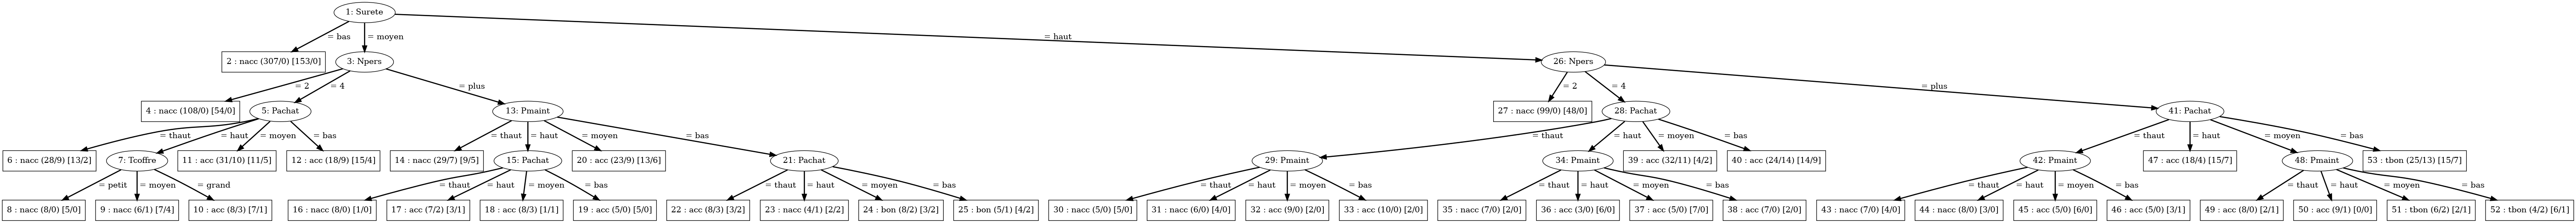

In [ ]:
reptree.visualize_tree()

In [ ]:
# # Step 1: Load the dataset into WEKA format
# # Replace "/path/to/Cars.xls" with the actual path to your dataset
# data = pd.read_csv("/content/cars.csv")

# # Save the DataFrame as an ARFF file
# dataframe_to_arff(data, relation_name="cars")

# # Load the ARFF file using WEKA's loader
# loader = Loader(classname="weka.core.converters.ArffLoader")
# weka_data = loader.load_file("cars.arff")

# # Set the last column as the class attribute (target variable)
# weka_data.class_is_last()

# # Step 2: Initialize the RepTree classifier
# reptree = Classifier(classname="weka.classifiers.trees.REPTree")

# # Train the model
# reptree.build_classifier(weka_data)

# # Step 3: Evaluate the model
# evaluation = Evaluation(weka_data)
# evaluation.crossvalidate_model(reptree, weka_data, 10, Random(1))  # 10-fold cross-validation

# # Print results
# print(evaluation.summary())

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text

# Create a toy dataset
data = pd.DataFrame({
    'Hours of Study': [2, 4, 6, 8, 10],
    'Previous Grade': ['B', 'C', 'B', 'A', 'A'],
    'Pass Exam': ['No', 'No', 'Yes', 'Yes', 'Yes']
})

# Encode categorical data
data['Previous Grade'] = data['Previous Grade'].map({'A': 3, 'B': 2, 'C': 1})
data['Pass Exam'] = data['Pass Exam'].map({'Yes': 1, 'No': 0})

# Features and target
X = data[['Hours of Study', 'Previous Grade']]
y = data['Pass Exam']

# Train a Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X, y)

# Display the tree
tree_rules = export_text(tree, feature_names=['Hours of Study', 'Previous Grade'])
print(tree_rules)


|--- Hours of Study <= 5.00
|   |--- class: 0
|--- Hours of Study >  5.00
|   |--- class: 1



In [ ]:
# tree.rules# Manually correct the text based on the structure of the table
corrected_csv = """Age,Spectacle prescription,Astigmatism,Tear production rate,Recommended lenses
Young,Myope,No,Reduced,None
Young,Myope,No,Normal,Soft
Young,Myope,Yes,Reduced,None
Young,Myope,Yes,Normal,Hard
Young,Hypermetrope,No,Reduced,None
Young,Hypermetrope,No,Normal,Soft
Young,Hypermetrope,Yes,Reduced,None
Young,Hypermetrope,Yes,Normal,Hard
Pre-presbyopic,Myope,No,Reduced,None
Pre-presbyopic,Myope,No,Normal,Soft
Pre-presbyopic,Myope,Yes,Reduced,None
Pre-presbyopic,Myope,Yes,Normal,Hard
Pre-presbyopic,Hypermetrope,No,Reduced,None
Pre-presbyopic,Hypermetrope,No,Normal,Soft
Pre-presbyopic,Hypermetrope,Yes,Reduced,None
Pre-presbyopic,Hypermetrope,Yes,Normal,None
Presbyopic,Myope,No,Reduced,None
Presbyopic,Myope,No,Normal,None
Presbyopic,Myope,Yes,Reduced,None
Presbyopic,Myope,Yes,Normal,Hard
Presbyopic,Hypermetrope,No,Reduced,None
Presbyopic,Hypermetrope,No,Normal,Soft
Presbyopic,Hypermetrope,Yes,Reduced,None
Presbyopic,Hypermetrope,Yes,Normal,None"""

# Save the corrected CSV to a file
output_path = "lenses_data.csv"
with open(output_path, "w") as file:
    file.write(corrected_csv)

output_path


'lenses_data.csv'